In [1]:
%%time
%matplotlib inline
import importlib
import new_import  
importlib.reload(new_import)
from new_import import *

CPU times: user 8.14 s, sys: 6.04 s, total: 14.2 s
Wall time: 8.08 s


In [2]:
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()
client

An existing cluster was found. Connecting to: easihub.f9d83b51e08f49b6b39322eddc9b27ee


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.f9d83b51e08f49b6b39322eddc9b27ee/status,


In [51]:
date_range = ('2023-05-01', '2024-06-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

coordinates = (longtitude_range, latitude_range)

In [52]:
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

<xarray.Dataset>
Dimensions:      (time: 32, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2023-05-04T22:46:11.500000 ... 2024-05...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 79, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2023-05-05T03:35:29.183000 ... 2024-05...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [53]:
average_vv = calculate_average(dsvv, time_pattern='1M')
progress(average_vv)

VBox()

In [54]:
average_vh = calculate_average(dsvh, time_pattern='1M')
progress(average_vh)

VBox()

In [55]:
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

VBox()

In [56]:
# calculate NDVI
dsNDVI = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = dsNDVI["NDVI"]

In [57]:
# calculate average NDVI
average_ndvi = calculate_average(ndvi,time_pattern="1M")
progress(average_ndvi)

VBox()

In [58]:
%%time
average_vh.compute()
average_vv.compute()
average_ndvi = average_ndvi.compute()

CPU times: user 224 ms, sys: 82.2 ms, total: 306 ms
Wall time: 1min 47s


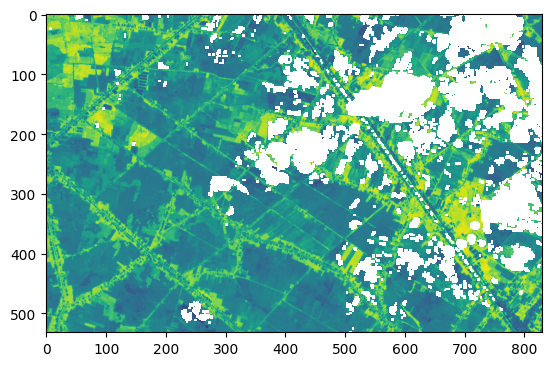

In [59]:
plt.imshow(average_ndvi.isel(time=0), vmin=None, vmax=None)

LOAD FILL CLOUD MODEL

In [60]:
fill_nan_model = joblib.load("output/regressors/gb_cloud.pkl")
mask = ~np.isnan(average_ndvi)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [61]:
X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)
average_ndvi.values[~mask] = fill_nan_model.predict(X_pred)
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

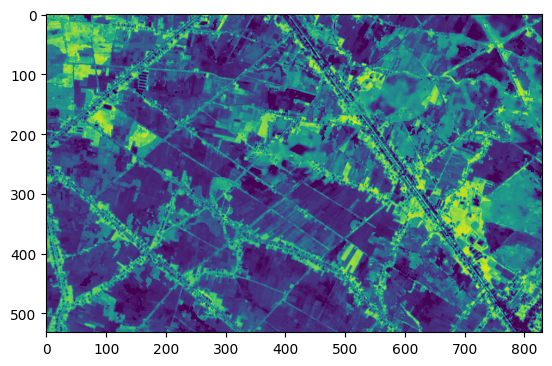

In [62]:
plt.imshow(average_ndvi.isel(time=0), vmin=0, vmax=1)

LOAD CLASSIFY MODEL

In [46]:
classif_path = "output/classifiers/rf_classify.pkl"
classify_model = joblib.load(classif_path)

In [20]:
data_array = predict(classify_model, data_sen2.rio.crs, average_ndvi, average_vh, average_vv)

DRAW IMAGE

/tmp/ipykernel_2253/1099579276.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


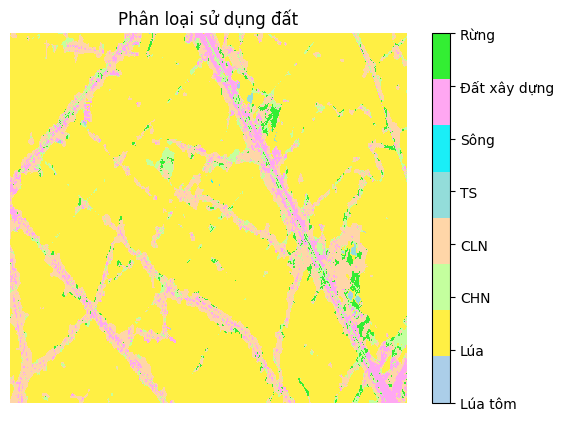

In [21]:
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [22]:

path = "input/ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"

region_result = cut_according_shp(path, average_ndvi, data_array)

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [25]:
# hiển thị kết quả phân loại sử dụng đất
colorval = list(range(len(colors)))
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
region_result.hvplot(
    rasterize = True,                  # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),    # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   []
   :Image   [x,y]   (value)

In [24]:
region_result.rio.to_raster("output/classified_results/classidied_rf.tif")

###############################
TEST IN 300 POINTS###############################


In [63]:
geo_path = "input/train_points/300/ThuanHoa_DKS_Kappa_new.shp"
points_label = load_data_geo(geo_path)
points_label.head()

,STT,LULC,Code,geometry
0,1,Dat xay dung,6,POINT Z (601020.539 1068835.423 0.000)
1,2,CLN,3,POINT Z (600992.765 1068892.073 0.000)
2,3,Dat xay dung,6,POINT Z (600983.261 1068711.965 0.000)
3,4,Lua,1,POINT Z (600885.708 1069333.342 0.000)
4,5,Dat xay dung,6,POINT Z (600129.865 1069351.996 0.000)


In [64]:
def extract_data_point(train, average_ndvi, dsvh, dsvv):
    loaded_datasets = {}
    for idx, point in train.iterrows():
        key = f"point_{idx + 1}"
        try:
            ndvi_data = average_ndvi.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
            vh_data = dsvh.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
            vv_data = dsvv.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
            loaded_datasets[key] = {
                "data": np.stack((ndvi_data, vh_data, vv_data), axis=0),
                "label": point.Code
            }
        except Exception as e:
            # Handle the exception if necessary
            print(f"Error at point {key}: {e}")
    return loaded_datasets

In [65]:
data_points = extract_data_point(points_label, average_ndvi_filled, average_vh, average_vv)
features, labels = create_dataset(data_points)

In [66]:
preds = classify_model.predict(features)

In [67]:
acc = accuracy_score(preds, labels)
print(f"Accuracy: {acc*100} %")

Accuracy: 54.18060200668896 %


In [ ]:
client.close()
cluster.close()